In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np

In [21]:
import sys
import os
sys.path.append(os.getenv('DEV_HOME'))
sys.path.append(os.getenv('SITES_HOME'))
import covid_ont
from covid_ont import dataset_read, dataset_get, DIR_IMAGES

In [3]:
df_cases_src=dataset_read('Cases & Tests')

In [4]:
df_cases_src.fillna(0, inplace=True)

In [5]:
df_cases_src.columns

Index(['Reported Date', 'Confirmed Negative', 'Presumptive Negative',
       'Presumptive Positive', 'Confirmed Positive', 'Resolved', 'Deaths',
       'Total Cases',
       'Total patients approved for testing as of Reporting Date',
       'Total tests completed in the last day',
       'Percent positive tests in last day', 'Under Investigation',
       'Number of patients hospitalized with COVID-19',
       'Number of patients in ICU due to COVID-19',
       'Number of patients in ICU, testing positive for COVID-19',
       'Number of patients in ICU, testing negative for COVID-19',
       'Number of patients in ICU on a ventilator due to COVID-19',
       'Num. of patients in ICU on a ventilator testing positive',
       'Num. of patients in ICU on a ventilator testing negative',
       'Total Positive LTC Resident Cases', 'Total Positive LTC HCW Cases',
       'Total LTC Resident Deaths', 'Total LTC HCW Deaths',
       'Total_Lineage_B.1.1.7', 'Total_Lineage_B.1.351', 'Total_Lineag

In [6]:
# there are some apparent errors in the original data where new cumulative counts are lower than those of the day before. The asusmption is that no deaths were reported for those days.
df_cases_src.iloc[[194,195]]

,Reported Date,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,...,Number of patients in ICU on a ventilator due to COVID-19,Num. of patients in ICU on a ventilator testing positive,Num. of patients in ICU on a ventilator testing negative,Total Positive LTC Resident Cases,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths,Total_Lineage_B.1.1.7,Total_Lineage_B.1.351,Total_Lineage_P.1
194,2020-08-18,0.0,0.0,0.0,951.0,37126.0,2793.0,40870.0,2631286.0,23067.0,...,16.0,10.0,6.0,5912.0,2622.0,1803.0,8.0,0.0,0.0,0.0
195,2020-08-19,0.0,0.0,0.0,965.0,37215.0,2792.0,40972.0,2656928.0,25642.0,...,18.0,10.0,8.0,5918.0,2626.0,1802.0,8.0,0.0,0.0,0.0


In [7]:
deaths=[]
for i in range(len(df_cases_src.index)):
    prev, curr = df_cases_src['Deaths'].iloc[i-1], df_cases_src['Deaths'].iloc[i]
    if curr>prev:
        deaths.append(curr-prev)
    else:
        deaths.append(1.0)
deaths[0]=0

In [8]:
df_deaths=df_cases_src[['Reported Date']].rename({'Reported Date': 'Date'}, axis=1)
df_deaths.set_index('Date', inplace=True)
df_deaths['Deaths']=deaths

In [9]:
df_cases_daily=dataset_read('Cases by PHU')[['Date', 'Total']]
df_cases_daily.columns=['Date', 'New Cases']
df_cases_daily.set_index('Date', inplace=True)
df_cases_daily.tail()

,New Cases
Date,
2021-05-02,3732
2021-05-03,3436
2021-05-04,2791
2021-05-05,2941
2021-05-06,3424


In [15]:
df_plot=pd.merge(df_deaths, df_cases_daily, on='Date')
df_plot.index=pd.to_datetime(df_plot.index)
df_plot

,Deaths,New Cases
Date,,
2020-03-24,2.0,0
2020-03-25,5.0,46
2020-03-26,2.0,69
2020-03-27,3.0,124
2020-03-28,1.0,0
...,...,...
2021-05-02,23.0,3732
2021-05-03,16.0,3436
2021-05-04,25.0,2791


In [41]:
def make_plot(df_plot):
    f_plot='deaths'
    fig, ax1 = plt.subplots(1, 1, figsize=(17,7))
    plt.style.use('fast')
    ax2=ax1.twinx()
    df_plot.plot(ax=ax1, kind='area', alpha=0.5, y='New Cases', color='red', label='Daily Cases')
    df_plot.plot(ax=ax2, kind='area', alpha=0.5, y='Deaths', color='black', label='Daily Deaths')
    ax1.set_xlabel('')
    ax1.set_ylabel('Cases', fontsize=20)
    ax2.set_ylabel('Deaths', fontsize=20)
    ax1.legend(loc=0, bbox_to_anchor=(0.15, 1.08))
    ax2.legend(loc=1, bbox_to_anchor=(0.965, 1.08))
    ax1.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax1.xaxis.set_major_formatter(DateFormatter("%d-%b-%Y"))
    ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.title('Daily Deaths vs Daily Cases', fontsize=18)
    fig.savefig(DIR_IMAGES + f_plot, facecolor='oldlace')

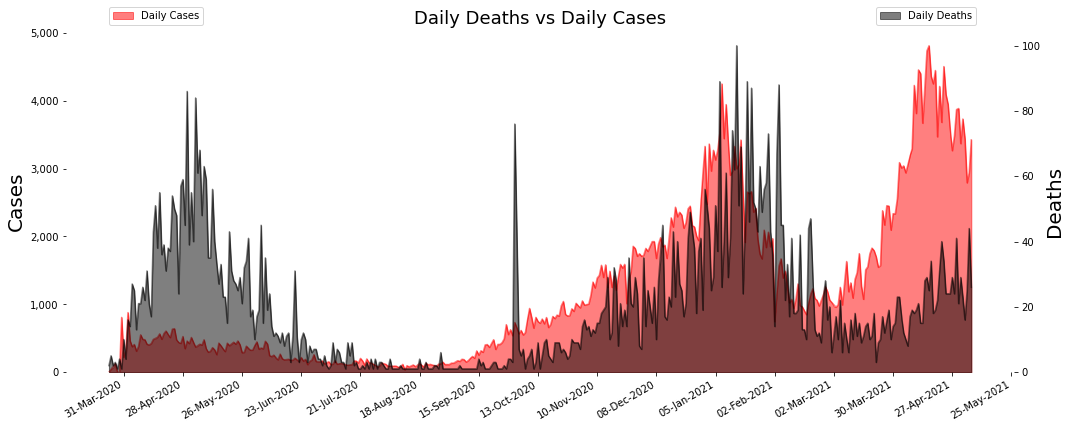

In [42]:
make_plot(df_plot)

In [12]:
df_deaths.sum()

Deaths    8283.0
dtype: float64